# トピックモデルでの予測

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import japanize_matplotlib

import numpyro
import numpyro.distributions as dist

import jax
import jax.numpy as jnp

import arviz as az
import seaborn as sns

from numpyro.contrib.control_flow import scan

In [2]:
numpyro.set_platform('cpu')
numpyro.set_host_device_count(5)

In [3]:
num_step = 100
step_size = 0.1
np.random.seed(1)

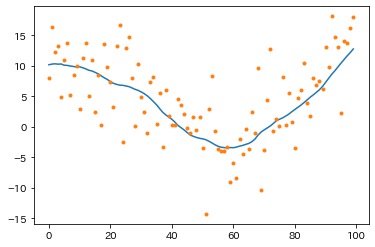

In [4]:
z = np.random.randn(num_step) * step_size
b = np.cumsum(z)
u = np.cumsum(b)
sigma = 5
c = 10
e = np.random.randn(num_step)

u = u + c
y = u + e * sigma

plt.figure()
plt.plot(u)
plt.plot(y, '.')

In [5]:
t = np.arange(len(y))
y = jnp.array(y)

In [39]:
# scan関数を用いたランダムウォーク関数の定義
def gaussian_random_walk(name, num_steps, scale=1.0):

    def transition_fn(u_prev, t):
        
        u_curr = numpyro.sample(name, dist.Normal(u_prev, scale))
        
        return u_curr, u_curr
    
    t = jnp.arange(num_steps)
    
    _, u = scan(transition_fn, 0.0, t)
    
    return u

## モデリング
- 基本的には前の章と同じだが、予測を行うために、ランダムウォークの関数を自前のものに置き換えているのと- 基本的には前の章と同じだが、予測を行うために、ランダムウォークの関数を自前のものに置き換えているのと`numpyro.handlers.condition`を使っている

In [38]:
def model(y_obs, future=0):
    
    num_steps = len(y_obs)

    # ランダムウォーク変数の分散パラの事前分布
    sd_b = numpyro.sample("sd_b", dist.HalfNormal(10))
    
    # ランダムウォーク
    b = gaussian_random_walk("b", num_steps + future, scale=sd_b)
    
    #トレンドモデルの初期値（バイアス）の事前分布
    c = numpyro.sample("c", dist.Normal(10))

    # ランダムトレンド（確率変数ではない）
    u = numpyro.deterministic("u", jnp.cumsum(b) + c)
    
    sd_y = numpyro.sample("sd_y", dist.HalfNormal(10))
    

    #観測モデル（スムーストレンド）
    with numpyro.handlers.condition(data={"y":y_obs}):
        
        def observer_fn(carry, uu):
    
            y = numpyro.sample("y", dist.Normal(uu, sd_y))
    
            return carry, y

        
        _, y = scan(observer_fn, None, u)
    
    if future > 0:
        # 予測分には別途名前付けとく
        numpyro.deterministic("y_pred", y[-future:])

In [12]:
nuts = numpyro.infer.NUTS(model, target_accept_prob=0.95)
mcmc = numpyro.infer.MCMC(nuts, num_warmup=1000, num_samples=1000, num_chains=5)

mcmc.run(jax.random.PRNGKey(1), y)

trace = mcmc.get_samples()

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [13]:
idata = az.from_numpyro(mcmc)

In [14]:
az.summary(idata, var_names=["c", "sd_b", "sd_y"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
c,10.090,0.839,8.453,11.575,0.013,0.009,4390.0,4063.0,1.00
sd_b,0.103,0.044,0.041,0.182,0.004,0.003,127.0,269.0,1.03
sd_y,4.752,0.352,4.104,5.403,0.005,0.003,6424.0,3222.0,1.00


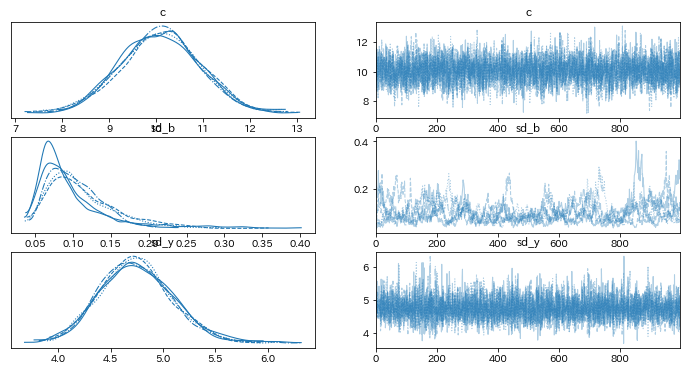

In [15]:
az.plot_trace(idata, var_names=["c", "sd_b", "sd_y"]);

In [16]:
u_sampled = trace["u"]

In [17]:
mu = jnp.mean(u_sampled,0)
pi = jnp.percentile(u_sampled, jnp.array([5, 95]), 0)

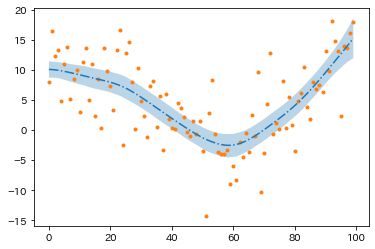

In [18]:
plt.plot(t, y, ".", color="C1")

plt.plot(t, mu, "-.")
plt.fill_between(t, pi[0,:], pi[1,:], alpha = 0.3);

In [19]:
observer_steps = len(y)
future_steps = 50

In [20]:
predictive = numpyro.infer.Predictive(model, trace, return_sites=["y_pred"])
samples = predictive(jax.random.PRNGKey(2), y, future=future_steps)

In [26]:
y_pred = samples["y_pred"]
t_pred = np.arange(observer_steps, observer_steps + future_steps)

In [31]:
mu_pred = jnp.mean(y_pred, 0)
pi_pred = jnp.percentile(y_pred, jnp.array([5, 95]), 0)

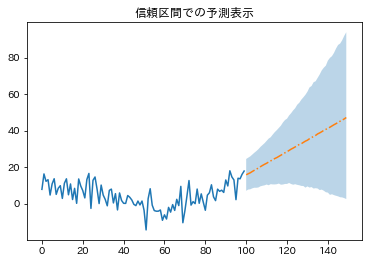

In [36]:
plt.plot(t, y)

plt.plot(t_pred, mu_pred, "-.")
plt.fill_between(t_pred, pi_pred[0, :], pi_pred[1, :], alpha=0.3)
plt.title("信頼区間での予測表示");

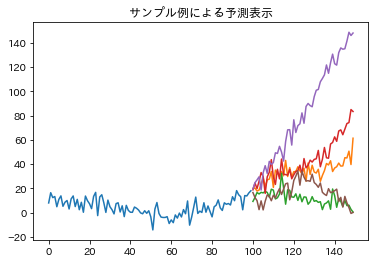

In [37]:
plt.figure()
plt.plot(t, y)
plt.plot(t_pred, y_pred[:5,].T)
plt.title("サンプル例による予測表示");